--- Starting ETL Pipeline ---
Datasets loaded successfully.
Processing Highest Degree...
Engineering Target and Tenure...
Engineering Salary Progression...
ETL Complete. Returning X, y, and Groups.

 Splitting & Preprocessing...
Training Shape: (201575, 70)
Testing Shape: (50515, 70)

 Starting Model Comparison...
Training Random Forest...
Training XGBoost...
Training MLP (Neural Net)...


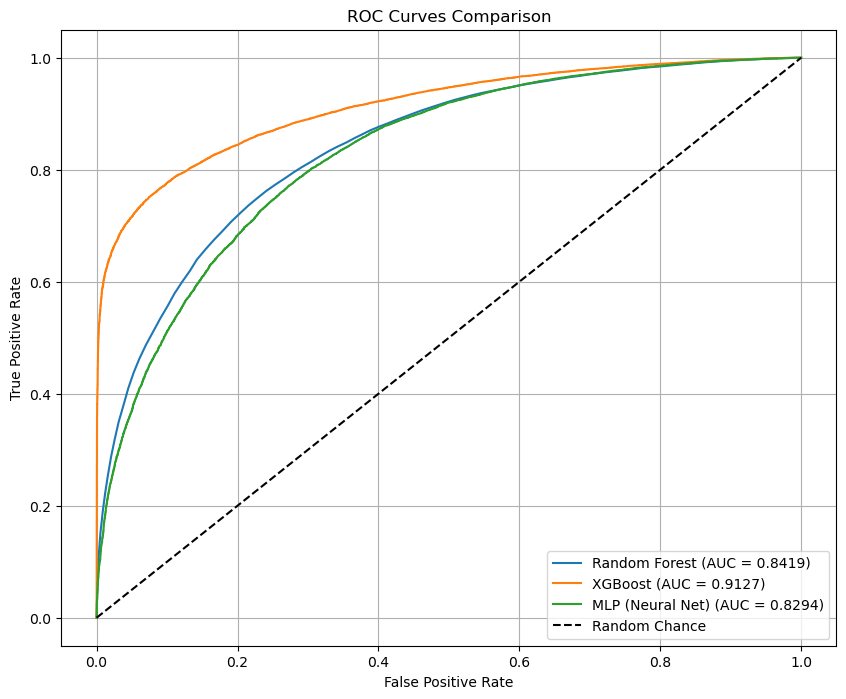


--- Comparison Results ---
Random Forest: AUC = 0.8419
XGBoost: AUC = 0.9127
MLP (Neural Net): AUC = 0.8294

 Best Model: XGBoost

--- Analysis based on XGBoost ---

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     14642
           1       0.88      0.89      0.88     35873

    accuracy                           0.83     50515
   macro avg       0.80      0.79      0.80     50515
weighted avg       0.83      0.83      0.83     50515



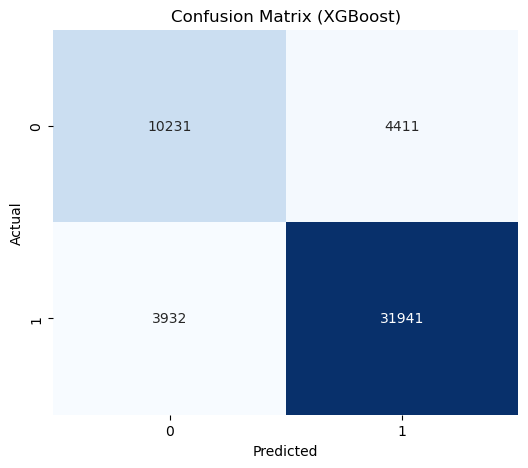


Calculating Permutation Importance...


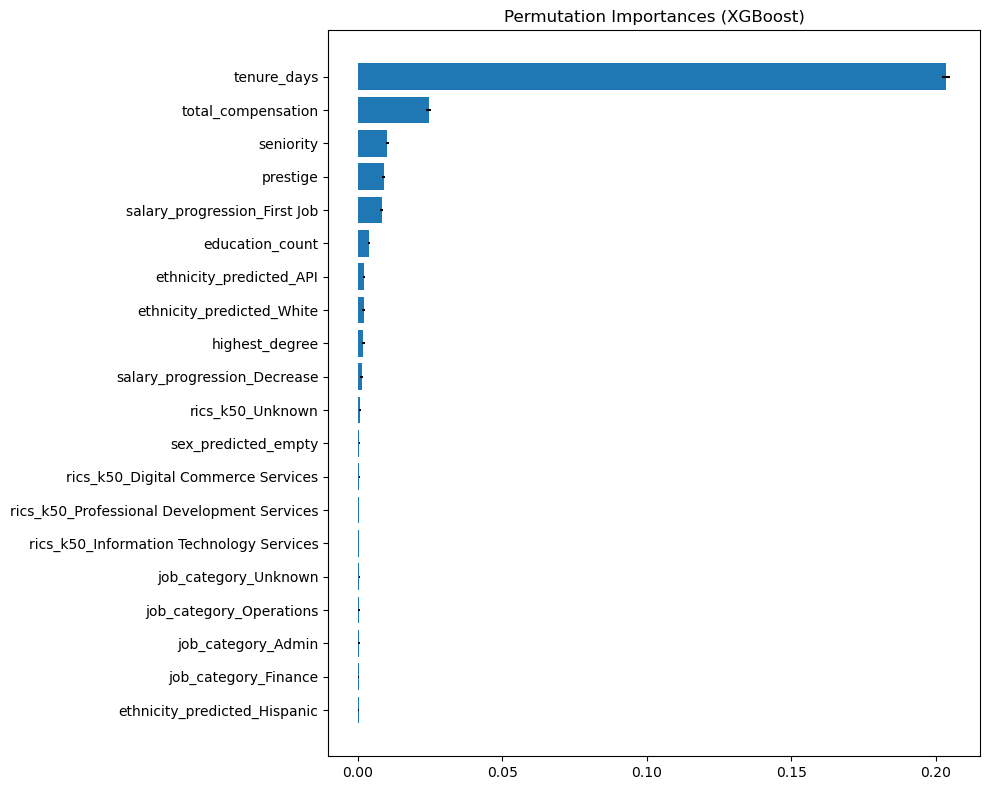


Generating Partial Dependence Plots...


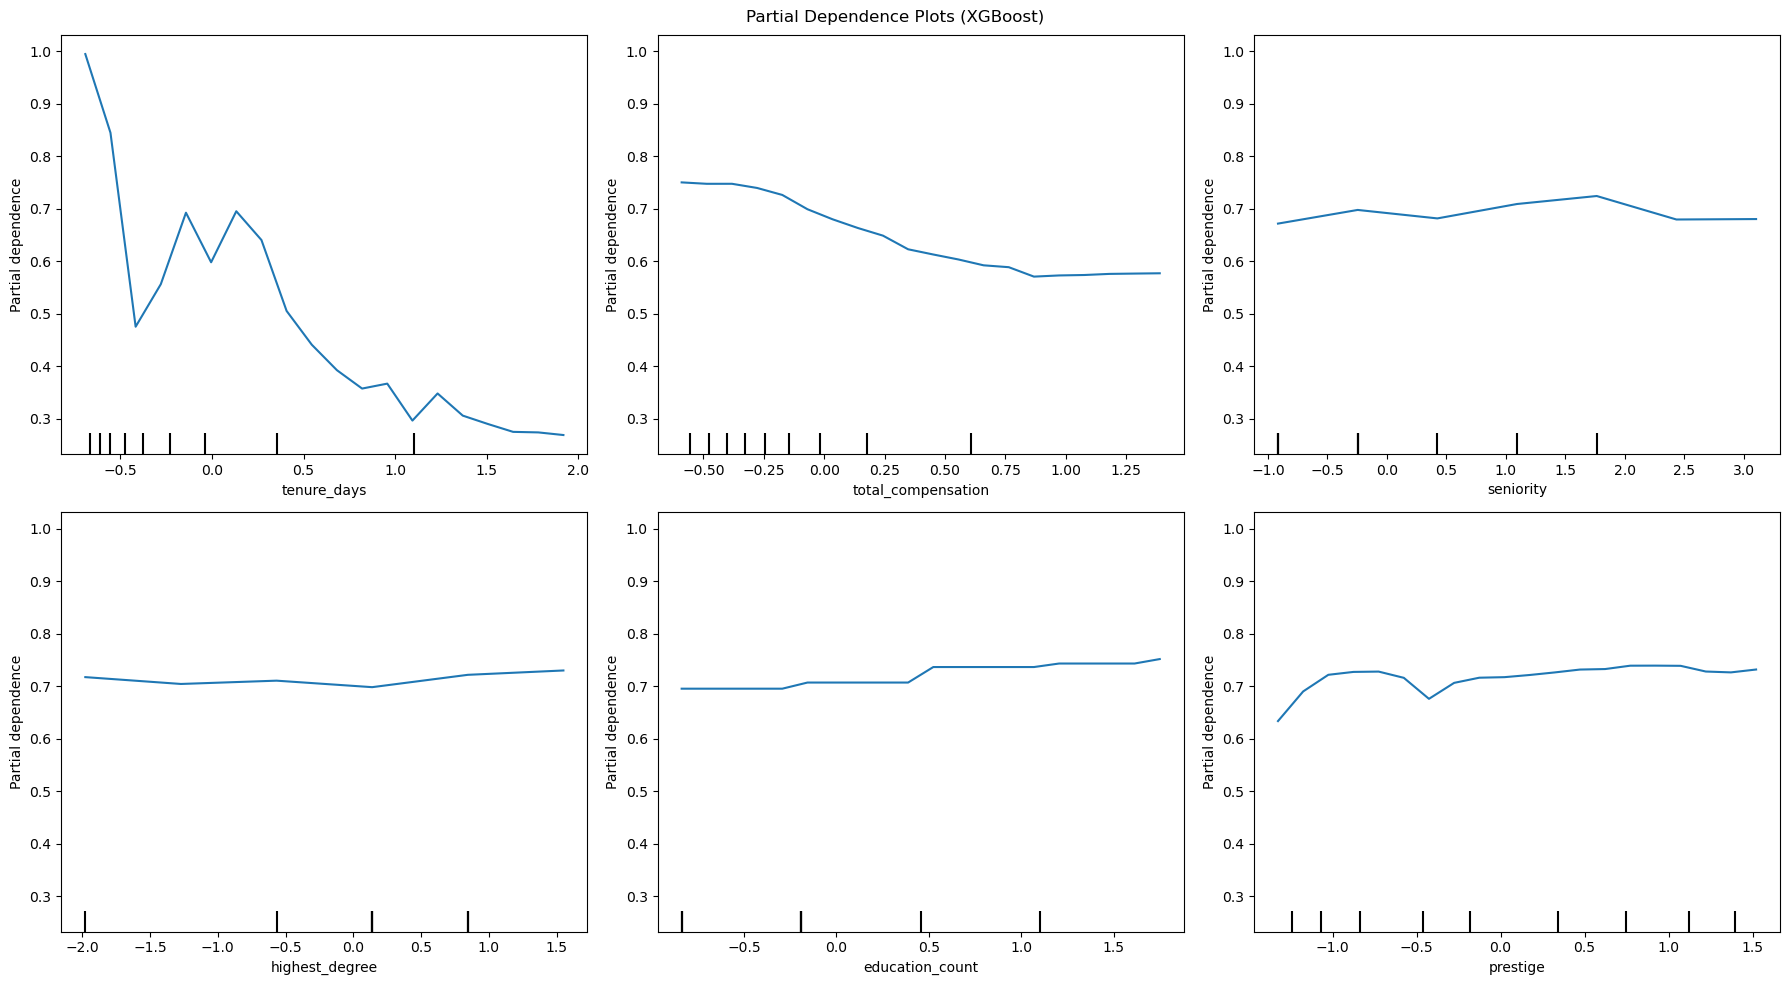


Pipeline complete. Best model saved to best_churn_model.pkl


In [1]:

#IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import re
import pickle
import warnings

# Sklearn Imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, 
    accuracy_score, precision_score, recall_score, f1_score
)

# XGBoost
import xgboost as xgb

# Neural Network (MLP)
from sklearn.neural_network import MLPClassifier

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
MODEL_FILENAME = 'best_churn_model.pkl'
RANDOM_STATE = 42


# ETL & FEATURE ENGINEERING FUNCTION

def load_and_process_data():
    print("--- Starting ETL Pipeline ---")
    
    # Load Datasets
    try:
        #df = pd.read_csv("/home/jbronyah/Downloads/individual_position_df_rand.csv")
        #df1 = pd.read_csv("/home/jbronyah/Downloads/individual_user_df_rand.csv")
        #df2 = pd.read_csv("/home/jbronyah/Downloads/individual_user_education_df_rand.csv")
        df = pd.read_csv("C:\\Users\\jbron\\Downloads\\ML\\Project\\individual_position_df_rand.csv")
        df1 = pd.read_csv("C:\\Users\\jbron\\Downloads\\ML\\Project\\individual_user_df_rand.csv")
        df2 = pd.read_csv("C:\\Users\\jbron\\Downloads\\ML\\Project\\individual_user_education_df_rand.csv")
        
        print("Datasets loaded successfully.")
    except FileNotFoundError:
        print("Error: One or more data files not found.")
        return None, None, None, None

    # --- A. Feature Engineering: University Rankings ---
    print("Processing Highest Degree...")

    def infer_education_level(row):
        # Using the processed 'degree' field
        degree = str(row['degree']).lower().strip()
        if degree != 'empty' and degree != 'nan':
            if 'doctor' in degree or 'phd' in degree: return 5
            if 'master' in degree or 'mba' in degree or 'm.sc' in degree: return 4
            if 'bachelor' in degree or 'b.sc' in degree or 'b.a.' in degree: return 3
            if 'associate' in degree: return 2
            if 'high school' in degree: return 1
    
        # Checking the 'degree_raw' field for keywords
        raw = str(row['degree_raw']).lower().strip()
        if raw != 'nan' and raw != 'empty':
    
            if re.search(r'(ph\.?d|doctor|d\.?phil|dba|dr\.|d\.?ed|d\.?sc|jur\.?dr|doktor|psyd)', raw): return 5
            if re.search(r'(master|mba|m\.?b\.?a|m\.?s\.?c|m\.?a|m\.?s|magister|llm|m\.?eng|m\.?tech|post.?grad|pós.?grad|mestrado|maestría|licentiate|engineer\'s degree|diplôme d\'ingénieur|laurea magistrale|硕士|diplom\b)', raw):
                return 4
            if re.search(r'\b(ma|ms)\b', raw): return 4
            if re.search(r'\b(b\.?s|b\.?a|b\.?sc|b\.?tech|b\.?e|llb|mbbs|b\.?com|b\.?b\.?a|b\.?eng|b\.?ed)\b', raw): return 3
            if re.search(r'(bachelor|bacharel|licenciatura|licence|undergraduate|graduação|baccalaureus|lisans|ingenier|engenheir|grado|gelar sarjana|laurea|sarjana|学士|titul|бакалавр|licencjat|학사)', raw):
                if 'high school' not in raw:
                    return 3
    
            if re.search(r'(associate|técnico|tecnico|bts|brevet|curso superior|大专|hnd|hnc)', raw):
                return 2
    
            if re.search(r'\b(aa|as|aas)\b', raw):
                return 2
    
            if 'diploma' in raw or 'certificate' in raw or 'cert' in raw:
                return 2
    
            if re.search(r'(high school|secondary|12th|matric|ged|bachillerato|abitur|hsc|sslc|ssc|a-level|intermediate|pre-u|baccalauréat|ensino m[ée]dio|gymnasium|vwo)', raw):
                return 1
            
            
    
        return 0 # Returning 0 if degree level unknown


    df2['education_level'] = df2.apply(infer_education_level, axis=1)
    
    df2_agg = df2.groupby('user_id').agg(
        max_education_level=('education_level', 'max'),
        education_count=('education_level', 'count')
    ).reset_index()

    df = pd.merge(df, df2_agg, on='user_id', how='left')
    df = pd.merge(df, df1, on='user_id', how='left')

    def compute_highest_ed_level(row):
        # Using the processed 'degree' field
        degree = str(row['highest_degree']).lower().strip()
        if degree != 'empty' and degree != 'nan':
            if 'doctor' in degree or 'phd' in degree: return 5
            if 'master' in degree or 'mba' in degree or 'm.sc' in degree: return 4
            if 'bachelor' in degree or 'b.sc' in degree or 'b.a.' in degree: return 3
            if 'associate' in degree: return 2
            if 'high school' in degree: return 1
    
        return 0 # Returning 0 if degree level unknown

    df['highest_degree'] = df.apply(compute_highest_ed_level, axis=1)
    df['highest_degree'] = np.where(df['highest_degree'] == 0, df['max_education_level'], df['highest_degree'])
    df.drop(['max_education_level'],inplace=True, axis=1)

    #removing ids and unimportant features
    df.drop([ 'position_id', 'company_raw', 'company_linkedin_url', 'location_raw', 'region', 'country', 'state',
       'metro_area', 'title_raw',
       'role_k50', 'role_k150', 'role_k300', 'role_k500', 'role_k1000',
       'role_k1500', 'weight', 'description',
       'rcid', 'company_name', 'ultimate_parent_rcid',
       'ultimate_parent_company_name', 'onet_code', 'onet_title', 'ticker',
       'exchange', 'cusip', 'naics_code', 'naics_description', 'ultimate_parent_factset_id',
       'ultimate_parent_factset_name', 'title_translated',
       'firstname', 'lastname', 'fullname', 'f_prob', 'm_prob', 'white_prob',
       'black_prob', 'api_prob', 'hispanic_prob', 'native_prob',
       'multiple_prob', 'profile_linkedin_url', 'user_location',
       'user_country', 'profile_title', 'updated_dt', 'numconnections',
       'profile_summary'],inplace=True,axis=1)




    # Target & Tenure Feature Engineering
    print("Engineering Target and Tenure...")
    df['churn'] = np.where(df['enddate'].isnull(), 0, 1)
    df['startdate'] = pd.to_datetime(df['startdate'], errors='coerce')
    df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')
    df = df.dropna(subset=['startdate'])
    
    analysis_date = max(df['startdate'].max(), df['enddate'].max())
    df['tenure_days'] = np.where(
        df['churn'] == 1,
        (df['enddate'] - df['startdate']).dt.days,
        (analysis_date - df['startdate']).dt.days
    )
    df = df[df['tenure_days'] >= 0]

    # Salary Progression Feature Engineering
    
    print("Engineering Salary Progression...")
    df = df.sort_values(by=['user_id', 'startdate'])
    df['previous_salary'] = df.groupby('user_id')['start_salary'].shift()
    df['percent_change'] = (df['start_salary'] - df['previous_salary']) / df['previous_salary']
    
    def map_progression(change):
        if pd.isna(change): return 'First Job'
        elif change > 0.05: return 'Increase'
        elif change < -0.05: return 'Decrease'
        else: return 'Stable'
    
    df['salary_progression'] = df['percent_change'].apply(map_progression)

    # Clean Categorical Strings
    categorical_cols = ['job_category', 'rics_k50', 'salary_progression', 'sex_predicted', 'ethnicity_predicted']

    def clean_strings(x):
        if pd.isna(x): return 'Unknown'
        s = str(x).strip()
        if '[' in s or ']' in s or 'E' in s: return 'Unknown'
        return s

    for col in categorical_cols:
        df[col] = df[col].apply(clean_strings)

    # Force numeric columns
    numeric_cols = ['tenure_days', 'total_compensation', 'seniority',
                    'highest_degree', 'education_count', 'prestige']


    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    print("ETL Complete. Returning X, y, and Groups.")
    return df, numeric_cols, categorical_cols

# Run ETL
df, num_features, cat_features = load_and_process_data()
X = df[num_features + cat_features]
y = df['churn']
groups = df['user_id']


# PREPROCESSING & SPLIT

print("\n Splitting & Preprocessing...")

# Split Data (Group-Aware to prevent leakage)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

# Define Preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'
)

# Transform Data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
try:
    ohe_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    feature_names = np.array(num_features + list(ohe_names))
except:
    feature_names = [f"Feature_{i}" for i in range(X_train_processed.shape[1])]

print(f"Training Shape: {X_train_processed.shape}")
print(f"Testing Shape: {X_test_processed.shape}")



#  MODEL COMPARISON (RF vs XGB vs MLP)

print("\n Starting Model Comparison...")

# Ratio calc for XGboost unbalanced dataset
#ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1) #when postive is less
#ratio = float(np.sum(y_train == 1)) / np.sum(y_train == 0) #when negative is less

# Define Models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=RANDOM_STATE, 
        n_jobs=-1
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        #scale_pos_weight=ratio,
        n_jobs=-1

    ),
    "MLP (Neural Net)": MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        activation='relu', 
        solver='adam', 
        random_state=RANDOM_STATE,
        early_stopping=True
    )
}

results = {}
best_model_name = ""
best_auc = 0
best_model_obj = None

plt.figure(figsize=(10, 8))

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_processed, y_train)
    
    # Predict probabilities
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    
    # Calculate Metrics
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    results[name] = auc
    
    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")
    
    # Track Best Model
    if auc > best_auc:
        best_auc = auc
        best_model_name = name
        best_model_obj = model

# Final Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.savefig('model_comparison_roc.png')
plt.show()

print("\n--- Comparison Results ---")
for name, score in results.items():
    print(f"{name}: AUC = {score:.4f}")

print(f"\n Best Model: {best_model_name}")



# Data Analysis based on Best Model

print(f"\n--- Analysis based on {best_model_name} ---")

# Confusion Matrix & Classification Report
y_pred = best_model_obj.predict(X_test_processed)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.savefig('best_model_confusion_matrix.png')
plt.show()

# Permutation Importance (Model Agnostic)
print("\nCalculating Permutation Importance...")
result = permutation_importance(
    best_model_obj, X_test_processed, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1][:20]

plt.figure(figsize=(10, 8))
plt.barh(
    np.array(feature_names)[sorted_idx][::-1], 
    result.importances_mean[sorted_idx][::-1],
    xerr=result.importances_std[sorted_idx][::-1],
    align='center'
)
plt.title(f"Permutation Importances ({best_model_name})")
plt.tight_layout()
plt.savefig('permutation_importance.png')
plt.show()

# Partial Dependence Plots (PDP) 
print("\nGenerating Partial Dependence Plots...")
top_numeric_features = [f for f in num_features if f in feature_names] 
features_to_plot = top_numeric_features[:6] # Plot top 6

if features_to_plot:

    n_cols = 3
    n_rows = (len(features_to_plot) + 2) // 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    ax = ax.flatten()
    
    PartialDependenceDisplay.from_estimator(
        best_model_obj,
        X_test_processed,
        features=features_to_plot,
        feature_names=feature_names,
        target=1,
        grid_resolution=20,
        ax=ax)

    for i in range(len(features_to_plot), len(ax)):
        ax[i].set_visible(False)
        
    plt.suptitle(f'Partial Dependence Plots ({best_model_name})')
    plt.tight_layout()
    plt.savefig('pdp_plots.png')
    plt.show()
else:
    print("Not enough numeric features for PDP.")

# Save the best model pipeline
with open(MODEL_FILENAME, 'wb') as f:
    pickle.dump({'preprocessor': preprocessor, 'model': best_model_obj}, f)
print(f"\nPipeline complete. Best model saved to {MODEL_FILENAME}")